# IMPORTS

In [27]:
##################
# IMPORT MODULES #
##################
# SYS IMPORT
import os, inspect, importlib, argparse
import random
import gc
import time
import pandas as pd
import numpy as np
from pathlib import Path

from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
import lightgbm as lgb 
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score, mean_squared_error, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# UTILS

In [28]:
def seed_everything(seed):
    """
    Seeds basic parameters for reproductibility of results
    
    Arguments:
        seed {int} -- Number of the seed
    """
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)

seed_everything(95)

# CONFIG

In [29]:
config = {
    "DATA_PATH" : "D:/Documents/GitHub/ml-pipeline/data/TPS-APR2021/train.csv",
    "TARGET_VAR" : "Survived"
}

# DATA & FEATURE ENGINEERING

In [30]:
df = pd.read_csv(config["DATA_PATH"])
target = df[config["TARGET_VAR"]]
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,1,1,"Oconnor, Frankie",male,NaN,2,0,209245,27.14,C12239,S
1,1,0,3,"Bryan, Drew",male,NaN,0,0,27323,13.35,NaN,S
2,2,0,3,"Owens, Kenneth",male,0.33,1,2,CA 457703,71.29,NaN,S
3,3,0,3,"Kramer, James",male,19.00,0,0,A. 10866,13.04,NaN,S
4,4,1,3,"Bond, Michael",male,25.00,0,0,427635,7.76,NaN,S


In [31]:
import datetime
import pandas as pd 
from sklearn.preprocessing import LabelEncoder
from pandas.api.types import is_integer_dtype, is_float_dtype, is_object_dtype

def missing_values(dataframe):
    # Droping features that have too many MV
    drop_features = ["Cabin", "Name", "Ticket"]
    dataframe = dataframe.drop(drop_features, axis=1)
    # DIVIDE INTO NUMERICAL FEATURES AND CATEGORICAL FEATURES
    integer_features = [col for col in dataframe.columns if is_integer_dtype(dataframe[col])]
    float_features = [col for col in dataframe.columns if is_float_dtype(dataframe[col])]
    object_features = [col for col in dataframe.columns if is_object_dtype(dataframe[col])]

    # WE REPLACE MISSING VALUES IN INTEGER  & FLOAT FEATURES WITH MEAN AND MODE FOR CATEGORICAL FEATURES
    dataframe[integer_features] = dataframe[integer_features].apply(lambda x: x.fillna(value=x.mean().astype(int)))
    dataframe[float_features] = dataframe[float_features].apply(lambda x: x.fillna(value=x.mean()))
    dataframe[object_features] = dataframe[object_features].apply(lambda x: x.fillna(value=x.mode()[0]))

    # ASSERT WE DON'T HAVE ANY MISSING VALUES IN THE DATASET
    assert dataframe.columns[dataframe.isnull().any()].empty, 'We still have some missing values in the dataset!'
    return dataframe

def get_cat_features(dataframe):
    categorical_features = [col for col in dataframe.columns if is_object_dtype(dataframe[col])]
    return categorical_features

def cat_encoding(dataframe, features):
    le = LabelEncoder()
    dataframe[features] = dataframe[features].apply(lambda x: le.fit_transform(x))
    return dataframe

def feature_engineering(dataframe, train=True):
    # FEATURE ENG
    dataframe = missing_values(dataframe)
    features_cat = get_cat_features(dataframe)
    dataframe = cat_encoding(dataframe, features_cat)
    features = dataframe.columns.difference(["Survived", "PassengerId", "kfold"])
    # RETURN DATAFRAME & ALL FEATURES NEEDED FOR TRAINING OR PREDICTION
    return dataframe, features

In [32]:
df, features = feature_engineering(df)
df.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,1,1,1,38.355472,2,0,27.14,2
1,1,0,3,1,38.355472,0,0,13.35,2
2,2,0,3,1,0.330000,1,2,71.29,2
3,3,0,3,1,19.000000,0,0,13.04,2
4,4,1,3,1,25.000000,0,0,7.76,2


In [33]:
df[features].head()

,Age,Embarked,Fare,Parch,Pclass,Sex,SibSp
0,38.355472,2,27.14,0,1,1,2
1,38.355472,2,13.35,0,3,1,0
2,0.330000,2,71.29,2,3,1,1
3,19.000000,2,13.04,0,3,1,0
4,25.000000,2,7.76,0,3,1,0


## SPLIT TRAIN AND VALID SETS

In [34]:
train_x, valid_x, train_y, valid_y = train_test_split(df[features], target, test_size=0.2, random_state=95)

## METRIC

In [35]:
acc = accuracy_score

# SELECT MODEL & CALCULATE METRICS

## MODEL PARAMETERS

In [36]:
LOGIT_parameters = {
    "max_iter" : 10000,
    "random_state"  : 95,
}

RF_parameters = {
    "max_depth" : 15, 
    "min_samples_split" : 7, 
    "min_samples_leaf" : 5,
    "max_features" : 5,
    "n_estimators" : 1000,
    "n_jobs" : -1,
    "random_state" : 95
}

LGBM_parameters = {
    'objective': 'binary',
    'metric' : 'auc',
    'n_estimators' : 1000,
    'random_state' : 95,
    'cat_smooth' : 30,
    'reg_alpha': 0.0031293275223408185,
    'reg_lambda': 0.04787145507141445,
    'colsample_bytree': 0.3,
    'subsample': 0.6,
    'learning_rate': 0.008,
    'max_depth': 100,
    'num_leaves': 584,
    'min_child_samples': 173
}

XGB_parameters = {
    "objective": "binary:logistic",
    "eval_metric" : "auc",
    "seed": 95,
    'tree_method': "gpu_hist",
    'predictor': 'gpu_predictor',
    'use_label_encoder' : False,
    "n_estimators" : 1000,
    'max_bin' : 64,
    "max_depth": 12, #Max should correspond to max number of features (probably ?),
    'alpha' : 11.607239831188968,
    'gamma' : 2.1593805822598444,
    "learning_rate": 0.02,
    "colsample_bytree": 0.8016656211574054,
    "subsample": 0.983461992112787,
    "reg_alpha" : 1.7306711078859136,
    "min_child_weight": 9.417969426623086,
    "n_jobs": 2
}

In [37]:
model_dict = {
    "LogisticRegression" : LogisticRegression(**LOGIT_parameters),
    "RFClassifier" : RandomForestClassifier(**RF_parameters),
    "LGBMClassifier" : lgb.LGBMClassifier(**LGBM_parameters),
    "XGBClassifier" : xgb.XGBClassifier(**XGB_parameters)
}

In [40]:
def compare_models(models, X_train, y_train, X_valid, y_valid, metric):
    scores = pd.DataFrame(columns = ['score', 'model'])
    for name, model in models.items():
        start = time.perf_counter()
        print(f"Training model : {name}")
        model.fit(X_train, y_train)
        preds = model.predict(X_valid)
        score = metric(y_valid, preds)
        end = time.perf_counter()
        print(f"Validation score : {score} in {end - start:0.4f} seconds")
        scores = scores.append({'score' : score, "model" : name}, ignore_index = True)      
    return scores

In [41]:
scores = compare_models(model_dict, train_x, train_y, valid_x, valid_y, accuracy_score)

Training model : LogisticRegression
Validation score : 0.76525 in 0.4608 seconds
Training model : RFClassifier
Validation score : 0.7665 in 18.5413 seconds
Training model : LGBMClassifier
Validation score : 0.77195 in 4.5167 seconds
Training model : XGBClassifier
Validation score : 0.77245 in 4.3636 seconds


In [34]:
scores.head()

,score,model
0,0.866934,LogisticRegression
1,0.881460,RFClassifier
2,0.894348,LGBMClassifier
3,0.891372,XGBClassifier


# AND THE WINNER IS ....

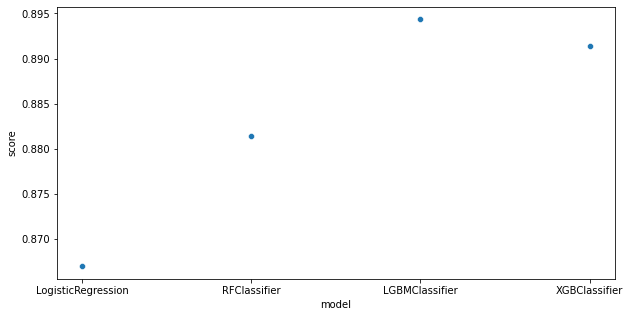

In [35]:
plt.figure(figsize = (10,5))
sns.scatterplot(data = scores, x = 'model', y = 'score')
plt.show()